In [1]:
import torch
import yaml
import os
import sys
import matplotlib.pyplot as plt

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

from models import *
from data_module import *
from forecast_module import *
from evaluation_module import *
from helpers import *
from observation_module import *
from tests.test_model import *

set_global_seed(42)

SCRIPT_DIR = os.getcwd()
sys.path.append(os.path.dirname(SCRIPT_DIR))
print(SCRIPT_DIR)

CONFIG = load_config(config_path = '../../configs/lstm_emulator.yaml')
HPARS = load_hpars(use_model = '../lstm')

cpu
/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator
/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator/notebooks
Opening ../../configs/lstm_emulator.yaml for experiment configuration.
{'clim_feats': ['clim_clake', 'clim_ldepth', 'clim_ctype', 'clim_cell_area', 'clim_glm', 'clim_cu', 'clim_cvh', 'clim_cvl', 'clim_tvh', 'clim_tvl', 'clim_sotype', 'clim_geopot', 'clim_sdfor', 'clim_sdor', 'clim_theta_cap', 'clim_theta_pwp', 'clim_veg_covh', 'clim_veg_covl', 'clim_veg_z0mh', 'clim_veg_z0ml', 'clim_veg_rsminh', 'clim_veg_rsminl'], 'dynamic_feats': ['met_ctpf', 'met_lwdown', 'met_psurf', 'met_qair', 'met_rainf', 'met_swdown', 'met_snowf', 'met_tair', 'met_wind_e', 'met_wind_n', 'lai_hv', 'lai_lv'], 'targets_prog': ['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc'], 'targets_diag': None, 'file_path': '/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr', 'start_year': 2015, 'end_year': 2019,

/perm/pamw/venvs/myevalenv/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Get Euclidean Distance.
Index of closest grid cell: [np.int64(4106)]
<xarray.Dataset> Size: 3MB
Dimensions:   (x: 1, time: 18744, variable: 33)
Coordinates:
    lat       (x) float32 4B 50.93
    lon       (x) float32 4B 6.573
  * time      (time) datetime64[ns] 150kB 2010-02-01 ... 2022-11-30T18:00:00
  * variable  (variable) object 264B 'met_ctpf' 'met_lwdown' ... 'slhf' 'es'
  * x         (x) int32 4B 62986
Data variables:
    data      (time, x, variable) float32 2MB ...
4106
Converting celsius into kelvin
Resampling to 6-hourly mean.
<xarray.DataArray 'st' (time: 5, station_id: 1, depth: 3)> Size: 60B
array([[[282.9    , 282.11667, 281.21667]],

       [[282.78333, 282.15   , 281.31665]],

       [[283.15   , 282.19998, 281.41663]],

       [[282.4    , 282.31668, 281.5167 ]],

       [[282.16666, 282.18335, 281.53333]]], dtype=float32)
Coordinates:
    lon         (station_id) float32 4B 6.324
    lat         (station_id) float32 4B 50.99
    network     (station_id) <U11 44B ...

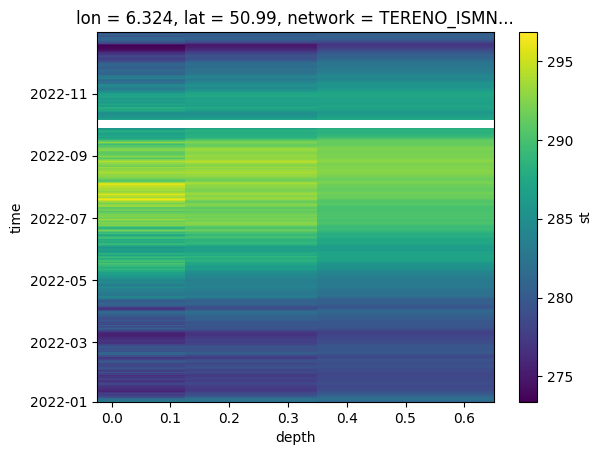

In [2]:
Gevenich = ObservationModule()
Gevenich.load_station()
Gevenich.load_forcing()
closest_grid_cell = Gevenich.match_station_with_forcing()[0]

print(closest_grid_cell)
CONFIG['x_slice_indices'] = closest_grid_cell

station_data = Gevenich.process_station_data()
print(station_data.shape)
Gevenich.plot_station_data()

To explore station data and ECLand forecasts, we load the untransformed data and plot it. ECLand slightly overestimates initial soil conditions in January, but most notably is the larger variance compared to the measurements in the first layer.

In [3]:
if CONFIG["model"] == 'mlp':
    ForecastModel = ForecastModuleMLP(hpars=HPARS, config=CONFIG)    
else:
    ForecastModel = ForecastModuleLSTM(hpars=HPARS, config=CONFIG)

dataset = ForecastModel.initialise_dataset()
model = ForecastModel.load_model()
x_static, x_met, y_prog = ForecastModel.load_test_data(dataset)  
print(x_static.shape)
print(x_met.shape)
print(y_prog.shape)

if CONFIG["model"] == 'lstm':
    test_forecast_shapes(model, x_static, x_met, y_prog)


Temporal start index 17408 Temporal end index 18743
Length of dataset: 1335
Using a single grid cell
Spatial size of data set: 1
Spatial indices of data set: 4106
Use all x_idx from data set.
isint
torch.Size([23])
[11, 10, 13, 0, 14, 12, 4, 3, 6, 5, 7, 2, 9, 8, 16, 15, 20, 19, 22, 21, 18, 17]
torch.Size([22])
torch.Size([1, 1, 22])
Set up model
Load model from checkpoint:  ../lstm/checkpoints/best-model-epoch=92-val_loss=0.00.ckpt
Matched keys
Select one grid cell from data
torch.Size([1, 1, 22])
torch.Size([1335, 1, 12])
torch.Size([1335, 1, 7])
y_h shape: torch.Size([1, 24, 1, 7])
X_static shape: torch.Size([1335, 1, 22])
X_static_h shape: torch.Size([1, 24, 1, 22])
X_met_h shape: torch.Size([1, 24, 1, 12])
X_static_f shape: torch.Size([1, 1311, 1, 22])
X_met_f shape: torch.Size([1, 1311, 1, 12])
out shape: torch.Size([1, 1311, 7])
Predictions shape: torch.Size([1, 1311, 1, 7])


From the dataset we loaded, we select the same global mean and standard deviation from the synthetic data to also z-score the station data. Then we explore their overlay. 

In [4]:
print("Evaluated variables:", CONFIG['targets_eval'])
print("Prognostic variables in emulator:", dataset.targ_lst)
station_data_transformed = Gevenich.transform_station_data(dataset=dataset, target_variables=CONFIG['targets_eval'])

Evaluated variables: ['stl1', 'stl2', 'stl3']
Prognostic variables in emulator: ['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc']


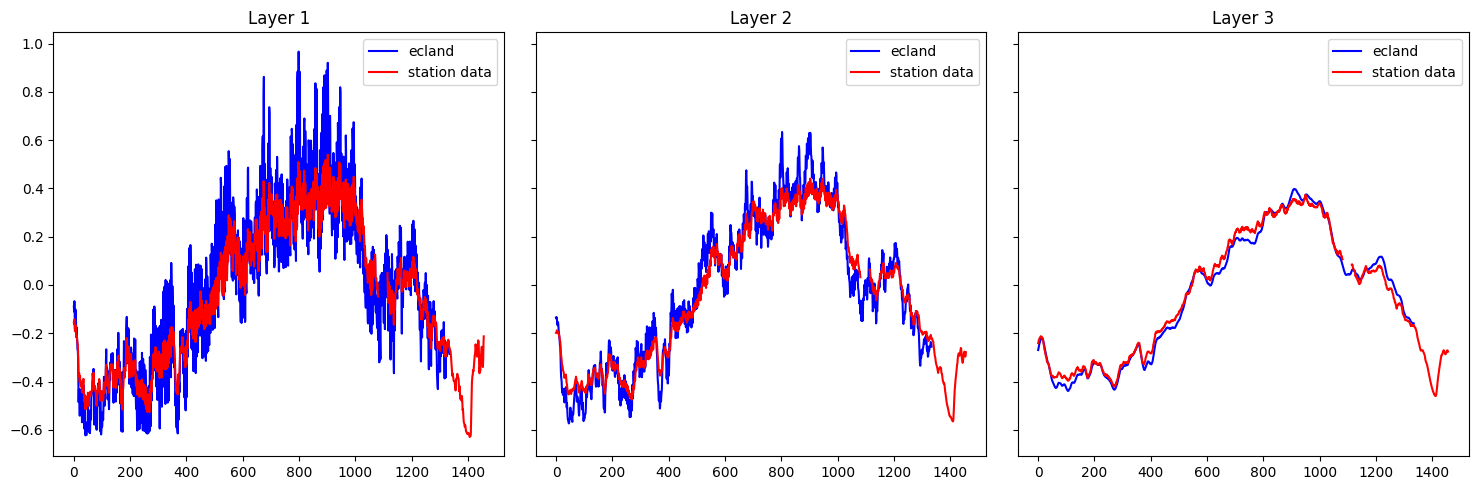

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True) 

ax[0].plot(y_prog[:,:,3], color="blue", label="ecland")
ax[0].plot(station_data_transformed[:,:,0], color="red", label="station data")
ax[0].set_title("Layer 1")
ax[0].legend()

ax[1].plot(y_prog[:,:,4], color="blue", label="ecland")
ax[1].plot(station_data_transformed[:,:,1], color="red", label="station data")
ax[1].set_title("Layer 2")
ax[1].legend()

ax[2].plot(y_prog[:,:,5], color="blue", label="ecland")
ax[2].plot(station_data_transformed[:,:,2], color="red", label="station data")  
ax[2].set_title("Layer 3")
ax[2].legend()

plt.tight_layout()
plt.show()


Now we create a hybrid data set with the z-scored station data for soil temperature, that we use for the prognostic initialsation, instead of the ECLand simulations as before. We further create an untransformed version of ECland simulations for visualisation. Then we initialise the model with the hybrid data and run the forecast

In [6]:
y_prog_hybrid = y_prog
y_prog_inv = dataset.prog_inv_transform(y_prog, means=dataset.y_prog_means, stds=dataset.y_prog_stdevs)
y_prog_hybrid[...,Gevenich.matching_indices] = station_data_transformed[:y_prog.shape[0]]

ForecastModel.set_forcing(x_static, x_met, y_prog_hybrid)
if CONFIG["model"] == 'lstm':
    ForecastModel.handle_hindcast(skip=False)
dynamic_features, dynamic_features_prediction = ForecastModel.run_forecast()
dynamic_features, dynamic_features_prediction = ForecastModel.backtransformation()

Model to device: cpu
Initialised prediction.
Y_prog_prediction shape: torch.Size([1335, 1, 7])
out shape: torch.Size([1, 1311, 7])
LSTM preds shape: torch.Size([1, 1311, 1, 7])
--- 0.0975179672241211 seconds ---
--- 0.0016252994537353516 minutes ---
y_prog shape:  torch.Size([1335, 1, 7])
y_prog_prediction shape:  torch.Size([1335, 1, 7])
Backtransforming


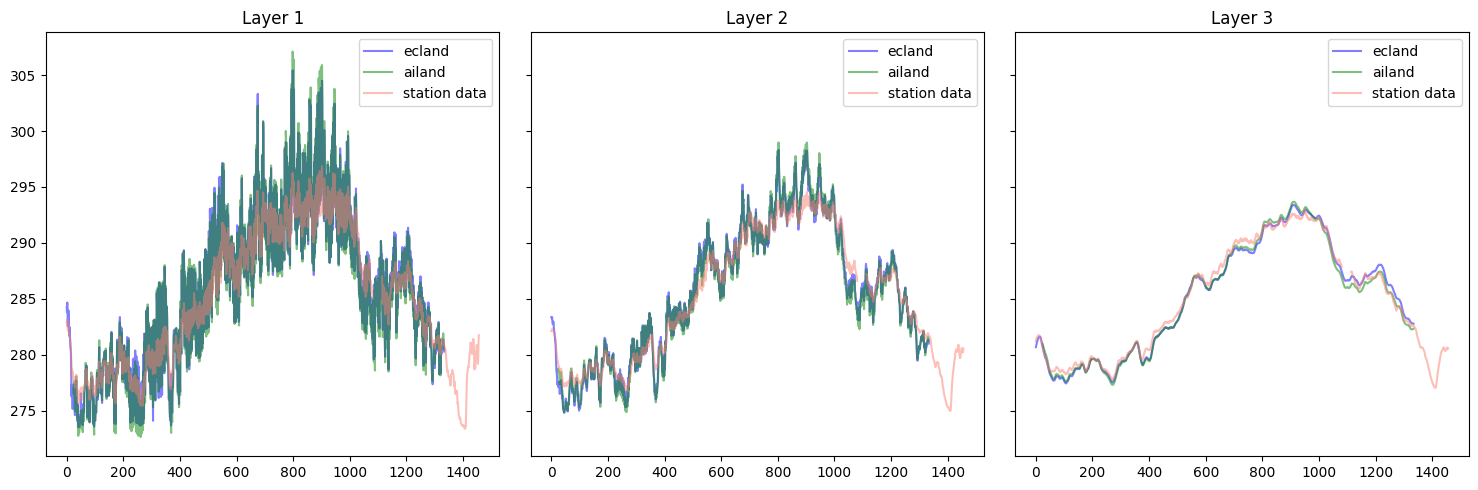

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True) 

ax[0].plot(y_prog_inv[:,:,3], color="blue", label="ecland", alpha = 0.5)
ax[0].plot(dynamic_features_prediction[:,:,3], color="green", label="ailand", alpha = 0.5)
ax[0].plot(station_data[:,:,0], color="salmon", label="station data", alpha = 0.5)
ax[0].set_title("Layer 1")
ax[0].legend()

ax[1].plot(y_prog_inv[:,:,4], color="blue", label="ecland", alpha = 0.5)
ax[1].plot(dynamic_features_prediction[:,:,4], color="green", label="ailand", alpha = 0.5)
ax[1].plot(station_data[:,:,1], color="salmon", label="station data", alpha = 0.5)
ax[1].set_title("Layer 2")
ax[1].legend()

ax[2].plot(y_prog_inv[:,:,5], color="blue", label="ecland", alpha = 0.5)
ax[2].plot(dynamic_features_prediction[:,:,5], color="green", label="ailand", alpha = 0.5)
ax[2].plot(station_data[:,:,2], color="salmon", label="station data", alpha = 0.5)  
ax[2].set_title("Layer 3")
ax[2].legend()

plt.tight_layout()
plt.show()


In [9]:
initial_vector = y_prog[0,...]
size = 10
sigma = 0.1

ensemble_prediction = []

for i in range(size):
    dynamic_features, dynamic_features_prediction = ForecastModel.run_forecast(initial_vector, perturbation = sigma)
    dynamic_features, dynamic_features_prediction = ForecastModel.backtransformation()
    ensemble_prediction.append(dynamic_features_prediction)

ensemble_prediction = torch.stack(ensemble_prediction)
print(ensemble_prediction.shape)
print(ensemble_prediction)

Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.20027589797973633 seconds ---
--- 0.0033379316329956053 minutes ---
y_prog shape:  torch.Size([1335, 1, 7])
y_prog_prediction shape:  torch.Size([1335, 1, 7])
Backtransforming
Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.1995704174041748 seconds ---
--- 0.0033261736234029135 minutes ---
y_prog shape:  torch.Size([1335, 1, 7])
y_prog_prediction shape:  torch.Size([1335, 1, 7])
Backtransforming
Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.19954466819763184 seconds ---
--- 0.0033257444699605304 minutes ---
y_prog shape:  torch.Size([1335, 1, 7])
y_prog_prediction shape:  torch.Size([1335, 1, 7])
Backtransforming
Initialised prediction.
Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.20212340354919434 seconds ---
--- 0.0033687233924865724 minutes ---
y_prog shape:  torch.Size([1335, 1, 7

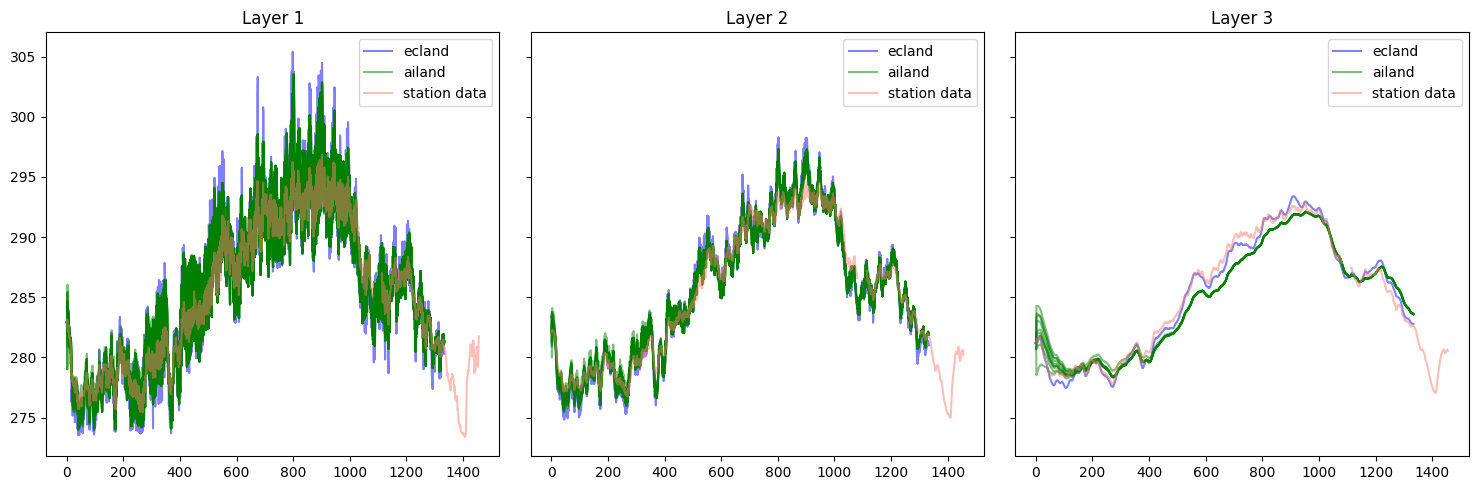

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True) 

ax[0].plot(y_prog_inv[:,:,3], color="blue", label="ecland", alpha = 0.5)
for i in range(size):
    label = "ailand" if i == 0 else None
    ax[0].plot(ensemble_prediction[i, :,:,3], color="green", label=label, alpha = 0.5)
ax[0].plot(station_data[:,:,0], color="salmon", label="station data", alpha = 0.5)
ax[0].set_title("Layer 1")
ax[0].legend()

ax[1].plot(y_prog_inv[:,:,4], color="blue", label="ecland", alpha = 0.5)
for i in range(size):
    label = "ailand" if i == 0 else None
    ax[1].plot(ensemble_prediction[i, :,:,4], color="green", label=label, alpha = 0.5)
ax[1].plot(station_data[:,:,1], color="salmon", label="station data", alpha = 0.5)
ax[1].set_title("Layer 2")
ax[1].legend()

ax[2].plot(y_prog_inv[:,:,5], color="blue", label="ecland", alpha = 0.5)
for i in range(size):
    label = "ailand" if i == 0 else None
    ax[2].plot(ensemble_prediction[i, :,:,5], color="green", label=label, alpha = 0.5)
ax[2].plot(station_data[:,:,2], color="salmon", label="station data", alpha = 0.5)  
ax[2].set_title("Layer 3")
ax[2].legend()

plt.tight_layout()
plt.show()


Then we evaluate both ECLand and AIland forecast:
1) Directly against the station data: $D(y_{ai}, y)$ and $D(y_{ec}, y)$
2) Then both against the observed climatology: $D(y_{ai}, y) / D(y_c, y)$ and $D(y_{ec}, y) / D(y_c, y)$

Dependent on what we want to report, we look at the ensemble scores over time, or at the spatially aggregated scores. D can here be the MSE, such that with 2) we compute the MSESS. It could also be the ACC.

Evaluation with rmse
shape of eval-array (1335,)
shape of eval-array-change (1334,)


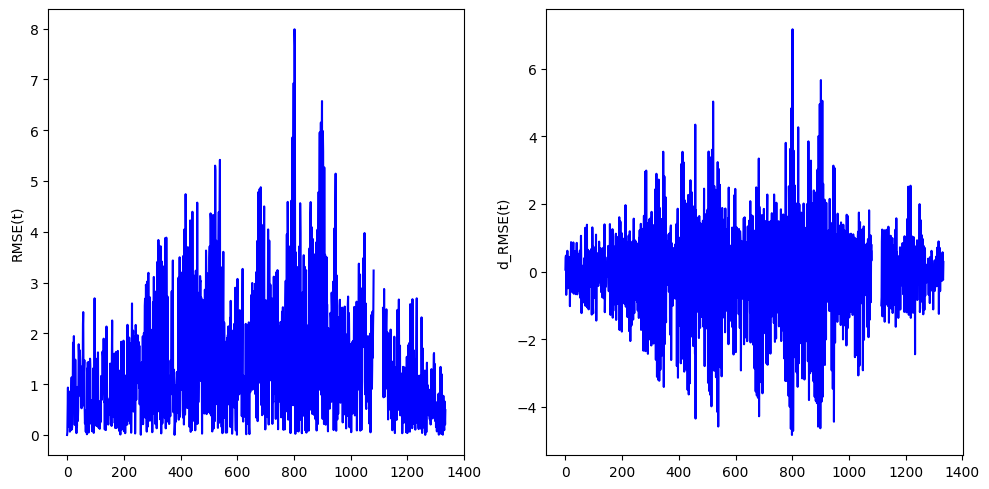

In [24]:
EvaluateMLP = EvaluationModule(score = 'rmse')
rmse_layer1 = EvaluateMLP.evaluate_target(y_prog=station_data[..., 0], y_prog_prediction=dynamic_features_prediction[..., 3])
rmse_layer1_change = rmse_layer1[1:] - rmse_layer1[:-1]
print("shape of eval-array", rmse_layer1.shape)
print("shape of eval-array-change", rmse_layer1_change.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True) 
ax[0].plot(rmse_layer1, color = "blue")
ax[0].set_ylabel("RMSE(t)")
ax[1].plot(rmse_layer1_change, color="blue")  
ax[1].set_ylabel("d_RMSE(t)")
plt.tight_layout()
plt.show()

In [33]:
mse_obs = np.sqrt(np.sum((dynamic_features_prediction - dynamic_features)**2, axis = 1))*(1/spatial_fields)
mse_clim = np.sqrt(np.sum((climatology - dynamic_features)**2, axis = 1))*(1/spatial_fields)
msess = 1 - (mse_obs[...,0]/mse_clim[...,0])
plt.plot(msess)

In [43]:
mse_obs = np.sqrt(np.sum((dynamic_features_prediction - dynamic_features)**2, axis = 1))*(1/spatial_fields)
mse_clim = np.sqrt(np.sum((climatology - dynamic_features)**2, axis = 1))*(1/spatial_fields)

mse_obs = np.sum(np.abs(dynamic_features_prediction - dynamic_features), axis = 1)*(1/spatial_fields)
mse_clim = np.sum(np.abs(climatology - dynamic_features), axis = 1)*(1/spatial_fields)


msess_L1 = 1 - (mse_obs[...,0]/mse_clim[...,0])
msess_L2 = 1 - (mse_obs[...,1]/mse_clim[...,1])
msess_L3 = 1 - (mse_obs[...,2]/mse_clim[...,2])

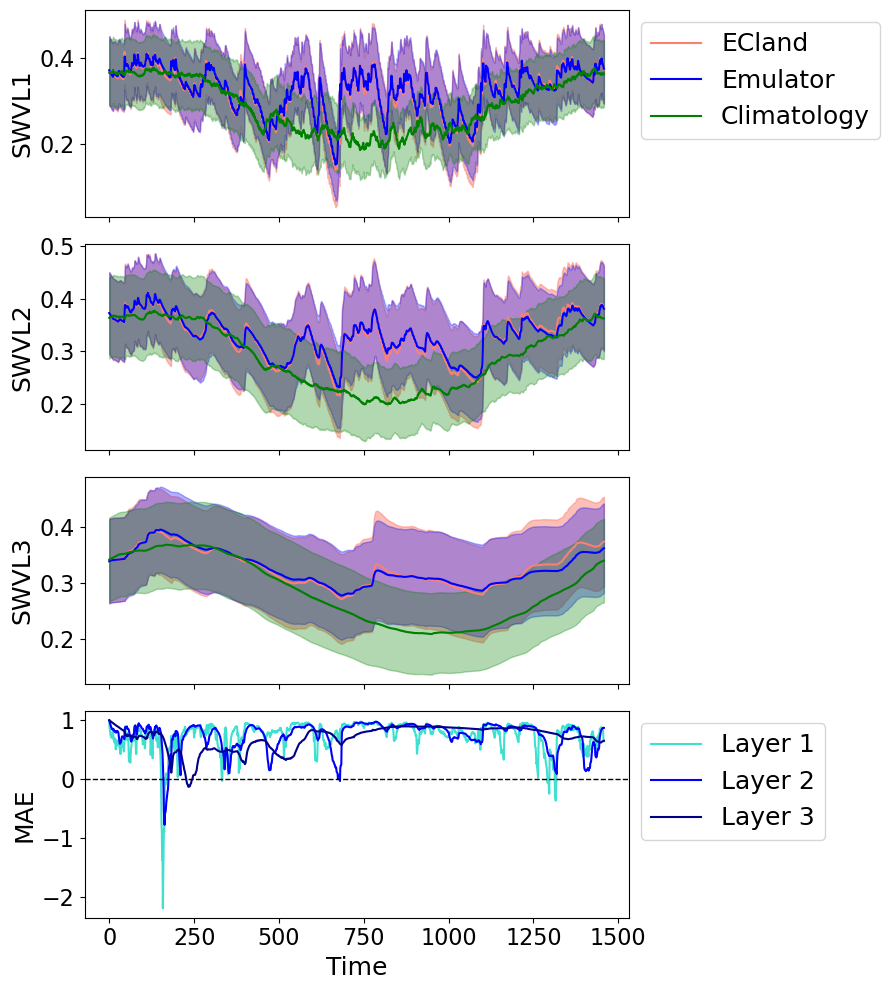

In [55]:
# Calculate mean and standard deviations
L1mean1 = np.mean(dynamic_features[...,0], axis=1)
L1std1 = dynamic_features[...,0].std(axis=1)

L1mean2 = np.mean(dynamic_features_prediction[...,0], axis=1)
L1std2 = dynamic_features_prediction[...,0].std(axis=1)

L1mean3 = np.mean(climatology_mu[:len(dynamic_features),:,0], axis=1)
L1std3 = climatology_mu[:len(dynamic_features),:,0].std(axis=1)

L2mean1 = np.mean(dynamic_features[...,1], axis=1)
L2std1 = dynamic_features[...,1].std(axis=1)

L2mean2 = np.mean(dynamic_features_prediction[...,1], axis=1)
L2std2 = dynamic_features_prediction[...,1].std(axis=1)

L2mean3 = np.mean(climatology_mu[:len(dynamic_features),:,1], axis=1)
L2std3 = climatology_mu[:len(dynamic_features),:,1].std(axis=1)

L3mean1 = np.mean(dynamic_features[...,2], axis=1)
L3std1 = dynamic_features[...,2].std(axis=1)

L3mean2 = np.mean(dynamic_features_prediction[...,2], axis=1)
L3std2 = dynamic_features_prediction[...,2].std(axis=1)

L3mean3 = np.mean(climatology_mu[:len(dynamic_features),:,2], axis=1)
L3std3 = climatology_mu[:len(dynamic_features),:,2].std(axis=1)

# Assuming L1mean1, L1std1, L1mean2, L1std2, etc. are defined
x = np.arange(1459)  # Example x-axis values for the tensors

# Create the plot with four subplots (4 rows, 1 column)
fig, axs = plt.subplots(4, 1, figsize=(9,10), sharex=True)

# Plot for Layer 1
axs[0].fill_between(x, L1mean1 - L1std1, L1mean1 + L1std1, color='salmon', alpha=0.5)
axs[0].plot(x, L1mean1, label='ECland', color='salmon')
axs[0].fill_between(x, L1mean2 - L1std2, L1mean2 + L1std2, color='blue', alpha=0.3)
axs[0].plot(x, L1mean2, label='Emulator', color='blue')
axs[0].fill_between(x, L1mean3 - L1std3, L1mean3 + L1std3, color='green', alpha=0.3)
axs[0].plot(x, L1mean3, label='Climatology', color='green')
axs[0].set_ylabel('SWVL1', fontsize=18)
axs[0].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))


# Plot for Layer 2
axs[1].fill_between(x, L2mean1 - L2std1, L2mean1 + L2std1, color='salmon', alpha=0.5)
axs[1].plot(x, L2mean1, label='ECland', color='salmon')
axs[1].fill_between(x, L2mean2 - L2std2, L2mean2 + L2std2, color='blue', alpha=0.3)
axs[1].plot(x, L2mean2, label='Emulator', color='blue')
axs[1].fill_between(x, L2mean3 - L2std3, L2mean3 + L2std3, color='green', alpha=0.3)
axs[1].plot(x, L2mean3, label='Climatology', color='green')
axs[1].set_ylabel('SWVL2', fontsize=18)
axs[1].legend().remove()

# Plot for Layer 3
axs[2].fill_between(x, L3mean1 - L3std1, L3mean1 + L3std1, color='salmon', alpha=0.5)
axs[2].plot(x, L3mean1, label='ECland', color='salmon')
axs[2].fill_between(x, L3mean2 - L3std2, L3mean2 + L3std2, color='blue', alpha=0.3)
axs[2].plot(x, L3mean2, label='Emulator', color='blue')
axs[2].fill_between(x, L3mean3 - L3std3, L3mean3 + L3std3, color='green', alpha=0.3)
axs[2].plot(x, L3mean3, label='Climatology', color='green')
axs[2].set_ylabel('SWVL3', fontsize=18)
axs[2].legend().remove()

# Plot for MAE in Layer 1, 2, 3
axs[3].plot(msess_L1, label='Layer 1', color='turquoise')
axs[3].plot(msess_L2, label='Layer 2', color='blue')
axs[3].plot(msess_L3, label='Layer 3', color='darkblue')
axs[3].axhline(0, color='black', linestyle='--', linewidth=1)  # Add the horizontal line at y=0
axs[3].set_xlabel('Time', fontsize=18)
axs[3].set_ylabel('MAE', fontsize=18)
axs[3].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))

axs[0].tick_params(axis='both', labelsize=16)
axs[1].tick_params(axis='both', labelsize=16)
axs[2].tick_params(axis='both', labelsize=16)
axs[3].tick_params(axis='both', labelsize=16)

# Adjust layout to remove vertical space between subplots
plt.subplots_adjust(hspace=0.1)  # Adjust the height space between plots

# Display the plot
plt.tight_layout()
plt.savefig("plots/ailand_horizons.pdf")
plt.show()
